In [9]:
import os, fnmatch 
import mesaPlot as mp
import numpy as np
import astropy.units as u
import astropy.constants as c 
import mesa_reader as mr
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

In [170]:

#######################################################################



#-------------------------------------------------------------------------------

def rhoav(r, m):
    """
    average density in g/cm**3
    """
    rhoav = (0.75 / np.pi) * m * r**(-3)
    if rhoav[0] == 0:
        rhoav[0] = rhoav[1]
    return rhoav.to(u.g * u.cm**(-3.))
#-------------------------------------------------------------------------------

def t_infall(r, m):
    """
    infall time in sec
    """
    rho_av = rhoav(r, m)
    time = (np.pi/(4*c.G*rho_av))**0.5
    return time.to(u.s)
#-------------------------------------------------------------------------------

def mdot(r, m, rho):
    """
    accretion rate in g/s
    """
    time = t_infall(r, m)
    rho_av = rhoav(r, m)
    acc = 2 * m / time * (rho/(rho_av-rho))
    return acc.to(u.Msun/u.s)
#-------------------------------------------------------------------------------

def r_gain(macc, m):
    """
    gain radius in cm
    """
    r0=12*u.km
    r1=120*u.km
        
    rg = ((macc.value / m.value**3 * (1.2e7**3) + (1.2e6)**3)**(1/3))*u.cm
    return rg.to(u.km)
#-------------------------------------------------------------------------------

def luminosity(mdot, m, r, r_gain, zeta = 0.7, t_15 = 1.2*u.s,redshift=False):
    """
    luminosity in erg/s
    """

    t_cool = t_15 * (m.to(u.Msun).value / 1.5) ** (5.0/3.0)
    t_cool = np.maximum(t_cool.value, 0.1)*u.s        
    Ebind = (m.to(u.Msun) - (-1. + (1+0.336*m.to(u.Msun).value)**0.5)*u.Msun/0.168)*c.c**2
        
    time = t_infall(r, m)
        
    rpns = 5.*r_gain/7.
        
    lnu = 0.3*Ebind/t_cool
    lacc = zeta*c.G*m*mdot/r_gain
        
    ldiff = lnu*np.exp(-np.minimum((time.to(u.s).value/t_cool.value),100))
    
    #
        
    lum = (lnu+ldiff)
    if redshift:
        alpha=np.maximum(0,(1-2*c.G*mass/rpns/c.c**2))
        lum = alpha**0.5 *lum
        
    return lum.to(u.erg/u.s)

    

def r_shock(mass,radius,rg,md,lum,aturb=1.17):
    rpns = 5*rg/7.
    alpha=np.maximum(0,(1-2.*c.G*mass/rpns/c.c**2))
    lume2 = lum.to(u.erg/u.s).value * 1e-52 * (mass.value)**2 * alpha ** 1.5
    rsh=aturb*0.55e5 * lume2**(4 / 9) * (rg.to(u.cm).value * 1.e-6)**(16 / 9) / (md.value**2 * mass.value)**(1/3)
    
    #rsh=aturb*0.55e5* ((lum.value/1e52)*alpha**3.)**(4/9) * mass.value**(5./9.) * (rg.to(u.km).value /10.)**(16./9.)  * md.value**(-2./3.)
    return rsh*u.cm


def t_adv(rs,mass,rg):
    tadv = 18*u.ms * (np.maximum(rs.to(u.km).value, 0.)/100.)**1.5 * np.log(np.maximum(rs.to(u.km).value/rg.to(u.km).value, 1)) * (mass.value)**(-0.5)
    #tadv = 18e-3 * (np.maximum(rs.to(u.cm), 0.) * 1.e-7)**1.5 * np.log(np.maximum((rs/rg).to(u.dimensionless_unscaled), 1)) * (mass.value)**(-0.5)
    #tadv = 18e-3 * (np.maximum(rs.to(u.cm), 0.) * 1.e-7)**1.5 * np.log(np.maximum(rs/rg, 1)) * (mass.value)**(-0.5)
    return tadv

def egain(mass,rs,rg,ediss=8.8*u.MeV/u.u):
    r = np.maximum(rs.to(u.km).value,rg.to(u.km).value)*u.km
 #   eg=3./4. * ediss + c.G * mass/4/r
    
    
    eg = (0.25 * c.G) * mass / np.maximum(rs, rg) + ediss * 0.75

    
    return eg.to(u.erg/u.g)

def t_heat(eg,rg,lum,mass):
    rpns = 5*rg/7.
    alpha=np.maximum(0,(1-2.*c.G*mass/(5*rg/7.)/c.c**2))
    lume2=lum.to(u.erg/u.s).value/1e52 * (mass.to(u.Msun).value)**2 * np.maximum(0,(1-2.*c.G*mass/rpns/c.c**2))  
    
    lume2 = lum.to(u.erg/u.s).value * 1e-52 * (mass.value)**2 * alpha ** 1.5
    
    
    theat = 150.*u.ms * (eg.to(u.erg/u.g).value / 1e19) * (rg.to(u.km).value / 100)**2 / np.maximum(lume2, 1e-80)

    #theat = 150*u.ms * (eg.to(u.erg/u.g).value / 1e19) * (rg.to(u.km).value / 100)**2 * np.maximum((lum.to(u.erg/u.s).value*1e-52 * alpha**3 * (mass.value)**2),1e-80)**(-1.)
    return theat 


def m_gain(ma,tadv):
    return (ma*tadv).to(u.Msun)


def nuc_energy(A1,A2,mu1,mu2,X,mtot):
     # A1 -> A2 + energy
    energy_per_reaction = ((A2*mu1 - A1*mu2)*u.mu*c.c**2).to(u.erg)
    reactions_per_gram = (1*u.g / (A2*mu1*u.mu)).to(u.dimensionless_unscaled)/u.g
    mtot = u.Quantity(mtot,u.Msun)
    return (energy_per_reaction*reactions_per_gram *(X*mtot)).to(u.erg)

def u_pre(mass,rs):
    return (2*c.G*mass/rs).to(u.km/u.s)

def rho_pre(mass,macc,radius,rs):
    return macc/(4*np.pi*radius**2 *u_pre(mass,rs))


def add_wind(m_by,lum0,rg,e_expl,m_grav,i_final,radius=1.2e6*u.cm,t_15=1.2*u.s):
    """
    Modifies the explosion energy and remenant mass by adding in the neutrino driven wind phase.

    """
    C=1                                                         # Proportionality constant for neutrino heating i   n the wind phase
    e_rec_alpha = 5 * u.MeV / u.u                               # Binding (recombination energy) ???
    epsilon_v = 9.5 * m_by.to(u.Msun).value *u.MeV                    # Mean neutrino energy

    t_cool = t_15 * (m_by / (1.5 * u.Msun)) ** (5.0/3.0)
    L_0 = lum0[i_final]                                         # Neutrino luminosity at the neutron star surface
  #  radius = rg[i_final]

    e_neutrino = L_0 * t_cool                                   # Total energy released by neutrino luminosity (assuming exp L decay)
    m_dot_0 = 1.14e-10 * C**(5/3) * (L_0.value/1e51)**(5/3) * epsilon_v.value**(10/3) * (radius.value/1e6) **(5/3) * (1.4*u.Msun/m_by)**2 * u.Msun/u.s

    m_wind = m_dot_0 * t_cool                                   # Mass lost in wind (baryonic)
    e_wind = m_wind * e_rec_alpha                               # Energy contribution in wind

    e_expl =  u.Quantity(e_expl,u.erg) + e_wind                               # Modifed explosion energy
    m_by   =  m_by-m_wind                                   # Modified neutron star remenant mass (baryonic)
    m_grav = (-1.0 + np.sqrt (1.0 + 4.0 * 0.084* m_by / u.Msun)) / (2 * 0.084)  * u.Msun

    if e_expl <=0:  # <-- No modification necessary if there is no explosion (i.e. black hole)
        e_wind     =  0.
        m_wind     =  0.
        
    return e_expl,m_by,m_grav,e_wind,m_wind



def eburn(p,T9,i,rho,beta=4):

    

    
    mass = p('mass')[::-1]*u.Msun
    mass   = (p('dq')*p('mass')[0])[::-1]
    m  = mass[i]
    h    = 1.007276
    he3  = 3.016029
    he4  = 4.002602
    c12  = 12.00000
    n14  = 14.00307
    o16  = 15.994915
    ne20 = 19.992440
    na23 = 22.989769
    mg24 = 23.985042
    si28 = 27.976927
    s32  = 31.972071
    ar36 = 35.967545
    ca40 = 39.962591
    ti44 = 43.582056 
    fe52 = 51.948113
    fe54 = 53.939609
    fe56 = 55.934937
    ni56 = 55.942129
    
    E = 0*u.erg
    mni56 = m*p('ni56')[::-1][i]
    if ((T9 >= 2.5) & (T9<3.5)):
            
            E += nuc_energy(1,16,h,o16,p('h1')[::-1][i],m)
            E += nuc_energy(4,16,he4,o16,p('he4')[::-1][i],m)         
            E += nuc_energy(12,16,c12,o16,p('c12')[::-1][i],m)
            E += nuc_energy(14,16,n14,o16,p('n14')[::-1][i],m)
    if ((T9 >= 3.5) & (T9<5)):
            E += nuc_energy(1,28,h,si28,p('h1')[::-1][i],m)
            E += nuc_energy(4,28,he4,si28,p('he4')[::-1][i],m)         
            E += nuc_energy(12,28,c12,si28,p('c12')[::-1][i],m)
            E += nuc_energy(14,16,n14,si28,p('n14')[::-1][i],m)
            E += nuc_energy(16,28,o16,si28,p('o16')[::-1][i],m)
            E += nuc_energy(20,28,ne20,si28,p('ne20')[::-1][i],m)
            E += nuc_energy(24,28,mg24,si28,p('mg24')[::-1][i],m)
    try:
        if (np.log10(beta*rho) < 11.62 + 1.5 * np.log10(T9)-39.17/T9) and (T9 > 5.):
                enuc = nuc_energy(1,56,h,ni56,p('h1')[::-1][i],m)
                E += enuc
                mni56 += m*p('h1')[::-1][i] - (enuc/c.c**2).to(u.Msun).value

                enuc = nuc_energy(4,56,he4,ni56,p('he4')[::-1][i],m)
                E += enuc 
                mni56 += m*p('he4')[::-1][i] - (enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(12,56,c12,ni56,p('c12')[::-1][i],m)
                E += enuc
                mni56 += m*p('c12')[::-1][i] - (enuc/c.c**2).to(u.Msun).value
                
                enuc =  nuc_energy(16,56,o16,ni56,p('o16')[::-1][i],m)
                E += enuc
     
                mni56 += m*p('o16')[::-1][i] - (enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(14,16,n14,ni56,p('n14')[::-1][i],m)
                E += enuc 
                mni56 += m*p('n14')[::-1][i] - (enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(20,56,ne20,ni56,p('ne20')[::-1][i],m)
                E += enuc 
                mni56 += m*p('ne20')[::-1][i] -(enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(24,56,mg24,ni56,p('mg24')[::-1][i],m)
                E += enuc 
                mni56 += m*p('mg24')[::-1][i] -(enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(28,56,si28,ni56,p('si28')[::-1][i],m)
                E += enuc
                mni56 += m*p('si28')[::-1][i] -(enuc/c.c**2).to(u.Msun).value
            
                enuc = nuc_energy(3,56,he3,ni56,p('he3')[::-1][i],m)
                E += enuc
                mni56 += m*p('he3')[::-1][i] -(enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(32,56,s32,ni56,p('s32')[::-1][i],m)
                E += enuc
                mni56 += m*p('s32')[::-1][i] -(enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(36,56,ar36,ni56,p('ar36')[::-1][i],m)
                E += enuc
                mni56 += m*p('ar36')[::-1][i] -(enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(40,56,ca40,ni56,p('ca40')[::-1][i],m)
                E += enuc
                mni56 += m*p('ca40')[::-1][i] -(enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(44,56,ti44,ni56,p('ti44')[::-1][i],m)
                E += enuc
                mni56 += m*p('ti44')[::-1][i] -(enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(52,56,fe52,ni56,p('fe52')[::-1][i],m)
                E += enuc
                mni56 += m*p('fe52')[::-1][i] -(enuc/c.c**2).to(u.Msun).value
                
                enuc = nuc_energy(54,56,fe54,ni56,p('fe54')[::-1][i],m)
                E += enuc
                mni56 += m*p('fe54')[::-1][i] -(enuc/c.c**2).to(u.Msun).value
    except ZeroDivisionError:
            pass
     
    return E,mni56 *u.Msun

In [11]:
class Lightcurve:
    def __init__(self,t,energy,ejecta,beta=13.8,electron_opacity=0.1,g_trap=0.03,m_Ni=2.5e-03):
        self.t    = (t * u.day).to(u.s)
        self.e_ej = energy * u.erg 
        self.m_ej = ejecta * u.Msun
        self.m_Ni = m_Ni * u.Msun 
        self.b_c  = beta 
        self.g_trap = g_trap
        self.k_e  = electron_opacity *  u.cm**2 * u.g**(-1.)
        self.usc  = ((10.*self.e_ej/(3.*self.m_ej))**0.5).to(u.cm/u.s)
        self.tau_m = 10*(self.m_ej.value)**(3./4.) * (self.e_ej.value/1e51)**(-1./4.) *(self.k_e.value/0.1)**(1./2.) * u.day
        self.tau_m = self.tau_m.to(u.s)
        self.x     = self.t/self.tau_m
        self.y  = self.tau_m/(2*(8.7*u.day).to(u.s))
        self.xy = self.x*self.y
        self.l_bol = self.lc()
        self.mag_bol = -2.5*np.log10((self.l_bol/u.Lsun).to(u.dimensionless_unscaled)) +4.74
        self.teff = (((3./4.)*self.l_bol / (np.pi * (self.t*self.usc)**2. * c.sigma_sb))**0.25).to(u.K)


    def D(self,decay_time,t):
        dt = (decay_time * u.day).to(u.s)
        x     = t/self.tau_m
        y  = self.tau_m/(2*dt)
        xy = x*y
        tau_g = 55.3*(0.1/self.g_trap)*y**2. /((self.usc.to(u.m/u.s)/c.c)*(0.1 + 2*xy)**2.)
        G = tau_g.value/(tau_g.value + 1.6)
        D = G*(1. + 2.*G*(1.-G)*(1.-0.75*G))
        return D


    def luminosity(self,t):
        t = t * u.s
        t_Ni = (8.7*u.day).to(u.s)
        t_co = (111.*u.day).to(u.s)
        l_Ni = 4.78e10 * (self.m_Ni.to(u.g).value) * np.exp(-t.value/(t_Ni.value))
        d_Ni = self.D(8.7,t)
        l_co = 2.561e8 *  (self.m_Ni.to(u.g).value) * (np.exp(-t.value/(t_co.value)) - np.exp(-t.value/(t_Ni.value)))/(1.-t_Ni/t_co)
        d_co = self.D(111.,t)
        return (l_Ni*d_Ni + l_co*d_co) * (u.erg/u.s)
            


  

    def lc(self):
        x  = self.t/self.tau_m
        out = np.zeros_like(x)
        fac = np.exp(-x.value**2.)
        for i in range(x.value.shape[0]):
            l = self.luminosity(self.t[:i].value).value*2.*x[:i]*np.exp(x[:i].value**2)/self.tau_m.value
            out[i] = np.trapz(l,self.t[:i].value)

        return fac*out * u.erg/ u.s


In [171]:
def criterion(profile,
              threshold = 1.0,
              beta=4.,
              alpha_outflow=0.5,
              eta_outflow = 0.5,
              zeta=0.7,
              aturb=1.18,
              t_15=1.2*u.s,
              m_max = 2.05 * u.Msun,
              wind=True,
              _use_egrav=False): 
    
    rho=(10**profile('logRho')[::-1])*u.g/(u.cm**3)
    mass=profile('mass')[::-1]*u.Msun
    radius=profile('radius')[::-1]*u.Rsun
    entropy=profile('entropy')[::-1]
    
    
    
    macc = mdot(radius,mass,rho)
    time = t_infall(radius,mass)
    rg   = r_gain(macc, mass)
    rpns = 5*rg/7.
    alpha= np.maximum(0,(1-2.*c.G*mass/(5*rpns/7.)/c.c**2))
    lum  =luminosity(macc, mass, radius, rg, zeta = zeta, t_15 = t_15)  
    rs   =r_shock(mass,radius,rg,macc,lum,aturb=aturb)
    
    tadv=t_adv(rs,mass,rg)
    eg=egain(mass,rs,rg,ediss=8.8*u.MeV/u.u)
    theat=t_heat(eg,rg,lum*alpha**0.5,mass)
    mgain=m_gain(macc,tadv)
    qheat = (eg * mgain) / theat
    eta_acc = qheat / macc
    tadv_theat = tadv / theat
    tadv_thead_max = tadv_theat.max()
    e_rec = 5 * u.MeV / u.u
    m_max_by  = m_max + 0.084 * m_max **2 / u.Msun
    

    
    
    try:
        jj0 = np.where(np.logical_and (tadv_theat > threshold, mass < m_max_by))[0][0]
        jj = np.arange(jj0, len(mass))
    except IndexError:
        jj = np.array([len(mass)-1], dtype = np.int)

    m_init = 0.0*u.Msun

    if len(jj) > 1:
        i_expl = np.min(jj)
        m_init = mass[i_expl - 1]
    else:
        i_final = len(mass)
        m_grav  = mass[-1]
              
    v_esc = np.sqrt(2 * c.G * mass/radius)

    e_diag = np.zeros_like(mass.value)*u.erg
    v_shock = np.zeros_like(mass.value)*u.km/u.s
    e_burn = 0.0 
    con_matzner = 0.794
    m_by_rem = m_init
    e_delayed = 0.
    m_neutrino = 0.0
    i_kick = 0
    if _use_egrav:
        ybind = -(3*c.G*mass**2/radius/5.).to(u.erg)
        #ybind=profile('total_energy')[::-1]*u.erg
    else:
        ybind=profile('total_energy_integral')[::-1]*u.erg
        
    m_out_dot = eta_outflow*eta_acc*macc/eg
    e_diag_dot = e_rec*m_out_dot
    
              
    mNi56 = 0.0*u.Msun
    v_kick=0 *u.km/u.s   
    e_expl = 0.0 *u.erg
    for i in jj[:-1]: 
        #eta_outflow = 1.0 - alpha_outflow
        dot_m_sh = (4.0 * np.pi * v_shock[i-1] * radius[i-1]**2 * rho[i-1]).to(u.Msun/u.s)
        scr1 = 1.0
        if (eta_outflow * dot_m_sh > macc[i]):
            scr1 = (macc[i] / dot_m_sh).to(u.dimensionless_unscaled)


        eta_1 = max( [(eta_acc[i] / np.abs(eg[i])), 0.0]).to(u.dimensionless_unscaled) # * alpha_outflow
        eta_2 =  eta_1 * scr1

        m_out = (mass[i] - mass[i-1]) * eta_2
        e_delayed = e_delayed + (mass[i] - mass[i-1]) * (eta_outflow * eta_1 - eta_2) * e_rec
        e_diag[i] = e_diag[i-1] + m_out * e_rec + (ybind [i-1] - ybind[i])  * alpha_outflow
        v_shock[i] = (con_matzner * np.sqrt(max(e_diag[i],0.0) / (mass[i] - m_init)) * ((mass[i] - m_init) / (rho[i] * radius[i]**3))**0.19)

        m_by_rem = m_by_rem + (mass[i] - mass[i-1]) * (1 - alpha_outflow)*(1.0-eta_1) #- m_out
        T9 = ((3/(c.sigma_sb*4./c.c))*(beta/(beta-1))*rho[i]*v_shock[i]**2)**0.25*1e-9
        #T9=((((3*beta-1.)/(beta*c.sigma_sb*4./c.c)*rho[i]*v_shock[i]**2)**(1./4.)).to(u.K)/1e9)
        eburn_i,dmni56 = eburn(profile,T9.value,i,rho[i].value,beta=beta)
        mNi56 += dmni56*alpha_outflow
        e_diag[i] += eburn_i*alpha_outflow
        m_grav = (-1 + np.sqrt (1 + beta * 0.084 * m_by_rem.value)) / (2 * 0.084) *u.Msun
    
        if (((beta-1)/beta) * v_shock[i] > v_esc[i]):
                i_final = i
                e_diag [i_final] = e_diag [i_final] #+ e_delayed
                e_expl = e_diag[i_final]
                i_kick = i_final
                break
        if (m_by_rem > m_max_by):
                m_by_rem = np.max(mass)
                m_grav = np.max(mass)
                e_expl = 0.
                e_delayed = 0.
                i_final = jj[-1]
                mNi56 = 0.
                break
        #m_grav = (-1 + np.sqrt (1 + beta * 0.084 * m_by_rem.value)) / (2 * 0.084) *u.Msun
        m_wind = 0.0
        e_wind = 0.0
        if m_by_rem > m_max_by:
            m_by_rem = np.max(mass)
            m_grav = m_by_rem
            e_expl = 0.*u.erg
            mNi56 = 0.*u.Msun
            i_final = jj[-1]
            
    for i in range(i_final+1, jj[-1]):
        e_diag[i] = e_diag[i-1]
        eexp = e_diag[i] + (ybind[i-1] - ybind[i])
        v_shock[i] = ((con_matzner * np.sqrt(max(eexp, 0) / (mass[i] - m_init)) * ((mass[i] - m_init) / (rho[i] * radius[i]**3))**0.19)).value*u.km/u.s
        T9 = ((3/(c.sigma_sb*4./c.c))*(beta/(beta-1))*rho[i]*v_shock[i]**2)**0.25*1e-9
        #T9=((((3*beta-1.)/(beta*c.sigma_sb*4./c.c)*rho[i]*v_shock[i]**2)**(1./4.)).to(u.K)/1e9)
        eburn_i,dmni56 = eburn(profile,T9.value,i,rho[i].value,beta=beta)
        mNi56 += dmni56*alpha_outflow
        e_diag[i] = eexp + eburn_i*alpha_outflow
        e_expl = e_diag[i]
        e_burn += eburn_i
         

    if (m_init >= m_max_by):
        m_init = 0.0
        m_grav = mass[-1]
        m_by_rem=mass[-1]
    if m_by_rem < m_max_by:
        e_expl = e_expl + e_delayed
        if m_by_rem.value != 0:
            v_kick = 211 * (0.05/0.1)*(e_expl.value/1e51)*(m_by_rem.value/1.5)**(-1.) * u.km/u.s
            if wind:
                e_expl,m_by_rem,m_grav,e_wind,m_wind=add_wind(m_by_rem,lum,rg,e_expl,m_grav,i_final) 
        else:
            v_kick= 0 *u.km/u.s
            if wind:
                m_wind = 0
    if e_expl.value < 1e45:
        m_by_rem = np.max(mass)
        m_grav = mass[-1]
        e_expl = 0.0*u.erg
        mNi56 = 0.0*u.Msun
        v_kick = 0 *u.km/u.s
        i_final = jj[-1]

    if mass[-1].value > 2.5:
            xi25 = interp1d(mass.value,mass.value/(radius.to(u.km).value/1000))(2.5).tolist()
    else:
            xi25 = 0.0
    if mass[-1].value > 1.7:
        xi17 = interp1d(mass.value,mass.value/(radius.to(u.km).value/1000))(1.7).tolist()
    else:
            xi17 = 0.0
                
    mc4  = interp1d(entropy,mass.value)(4.0).tolist()
    mu4  =0.3/((interp1d(mass.value,radius.to(u.km).value)(mc4+0.3)-radius[entropy>4][0].to(u.km).value)/1000.)
    mu4_mod = 0.33*mu4*mc4+0.09
    if wind: 
        m_ej=mass[-1]-m_by_rem+m_wind
    else:
        m_ej=mass[-1]-m_by_rem
        m_wind = 0*u.Msun

    
    result = {
        'm_grav': m_grav,
        'M_bar': m_by_rem,
        'M_ni56':mNi56,
        'E_expl':e_expl,
        'M_ej':m_ej,
        'M_wind':m_wind,
        'xi17':xi17,
        'xi25':xi25,
        'mu4':mu4,
        'mu4_mod':mu4_mod,
        'vkick':v_kick,
        'M_star':mass[-1],
        'R_star':radius[-1],
        'Rho_c':rho[0],
        'icut':i_final,
        'jj':jj[0],
        'tadv_thead_max':tadv_thead_max
    }
    
    return result


In [152]:
profile=mr.MesaData('13_cc.data',).data
criterion(profile,wind=True,_use_egrav=True,eta_outflow=1.0)

{'m_grav': <Quantity 1.57127876 solMass>,
 'M_bar': <Quantity 1.77866778 solMass>,
 'M_ni56': <Quantity 4.14352098 solMass>,
 'E_expl': <Quantity 7.70369513e+51 erg>,
 'M_ej': <Quantity 8.60041314 solMass>,
 'M_wind': <Quantity 0.00486581 solMass>,
 'xi17': 1.05180089584998,
 'xi25': 0.20785867031770044,
 'mu4': 0.07325838325188411,
 'mu4_mod': 0.13506449500312517,
 'vkick': <Quantity 679.39458274 km / s>,
 'M_star': <Quantity 10.37421511 solMass>,
 'R_star': <Quantity 0.42074472 solRad>,
 'Rho_c': <Quantity 6.30523192e+09 g / cm3>,
 'icut': 434,
 'jj': 353,
 'tadv_thead_max': <Quantity 2.40172347>}

In [174]:
profile=mr.MesaData('7_cc.data').data
criterion(profile,wind=True,_use_egrav=False)

{'m_grav': <Quantity 1.35688787 solMass>,
 'M_bar': <Quantity 1.51154402 solMass>,
 'M_ni56': <Quantity 2.03517687 solMass>,
 'E_expl': <Quantity 2.93965921e+51 erg>,
 'M_ej': <Quantity 4.1743398 solMass>,
 'M_wind': <Quantity 0.00352516 solMass>,
 'xi17': 0.5221558442463342,
 'xi25': 0.1349916561470729,
 'mu4': 0.062038569519711095,
 'mu4_mod': 0.12207438432680065,
 'vkick': <Quantity 303.51721533 km / s>,
 'M_star': <Quantity 5.68235866 solMass>,
 'R_star': <Quantity 0.41772813 solRad>,
 'Rho_c': <Quantity 1.27926082e+10 g / cm3>,
 'icut': 539,
 'jj': 481,
 'tadv_thead_max': <Quantity 4.70954125>}

In [162]:
profile=mr.MesaData('009.0_final_profile.data').data
criterion(profile,wind=True,_use_egrav=False)

{'m_grav': <Quantity 7.28006059 solMass>,
 'M_bar': <Quantity 7.28006059 solMass>,
 'M_ni56': <Quantity 0. solMass>,
 'E_expl': <Quantity 0. erg>,
 'M_ej': <Quantity 0. solMass>,
 'M_wind': 0,
 'xi17': 1.078989115963349,
 'xi25': 0.6834057547492276,
 'mu4': 0.1831975397051428,
 'mu4_mod': 0.23919568987848044,
 'vkick': <Quantity 0. km / s>,
 'M_star': <Quantity 7.28006059 solMass>,
 'R_star': <Quantity 0.34692135 solRad>,
 'Rho_c': <Quantity 2.78559701e+09 g / cm3>,
 'icut': 1792,
 'jj': 1792,
 'tadv_thead_max': <Quantity 0.02600117>}

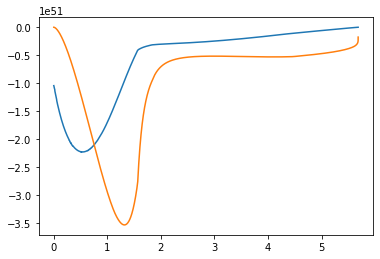

In [181]:
    rho=(10**profile('logRho')[::-1])*u.g/(u.cm**3)
    mass=profile('mass')[::-1]*u.Msun
    radius=profile('radius')[::-1]*u.Rsun

plt.plot(profile('mass'),profile('total_energy_integral'))

plt.plot(mass,-(3*c.G*mass**2/radius/5.).to(u.erg))
#plt.plot(profile('mass'),profile('total_energy'))
#plt.plot(mass,-mass**2./radius)

### 